In [118]:
import time
import inspect
import warnings
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [119]:
def wrangle(filepath,resample_rule="1H"):
    df = pd.read_csv(filepath,sep=';', encoding='latin-1')
    df["timestamp"]=df["timestamp"].str.replace("|" ," ")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index("timestamp", inplace=True)
    # Localize timezone
    
    df.index=df.index.tz_localize('UTC').tz_convert('Africa/Nairobi')
    # remove outliers
    df=df[df['P2']<500]
    # Resample and forward-fill
    y = df["P2"].resample(resample_rule).mean().fillna(method="ffill")
    return y

In [121]:
# import and wrangle the data
y =wrangle("data/nairobi-air-quality.csv")
y.head()

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\946001175.py:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



timestamp
2018-09-01 03:00:00+03:00    17.541667
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
Freq: H, Name: P2, dtype: float64

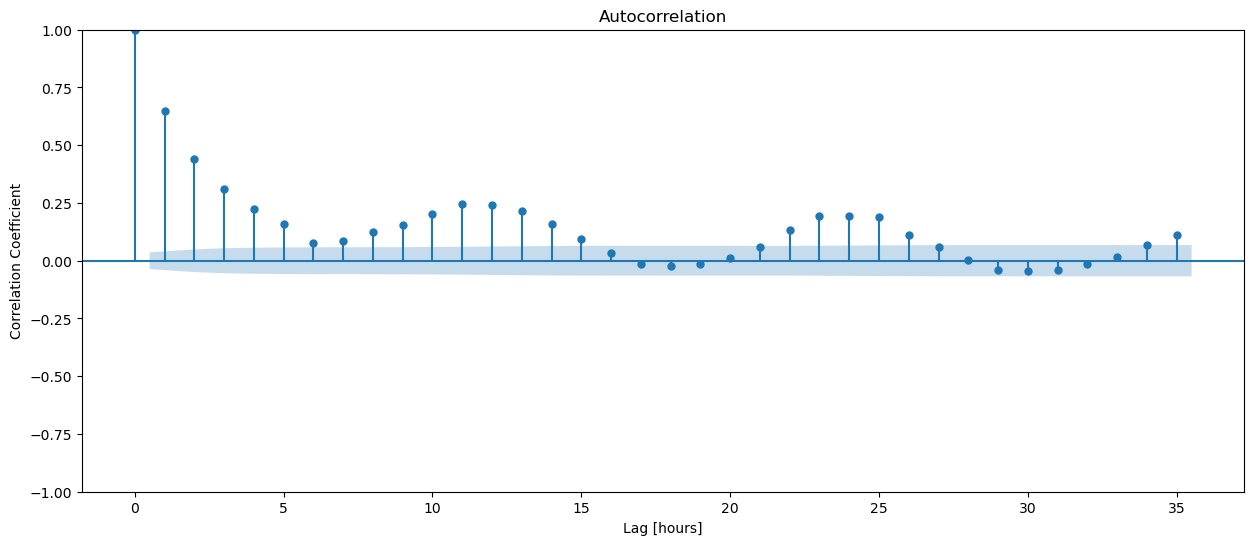

In [122]:
# ACF plot for the data
fig,ax=plt.subplots(figsize=(15,6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

C:\Users\PanDa\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



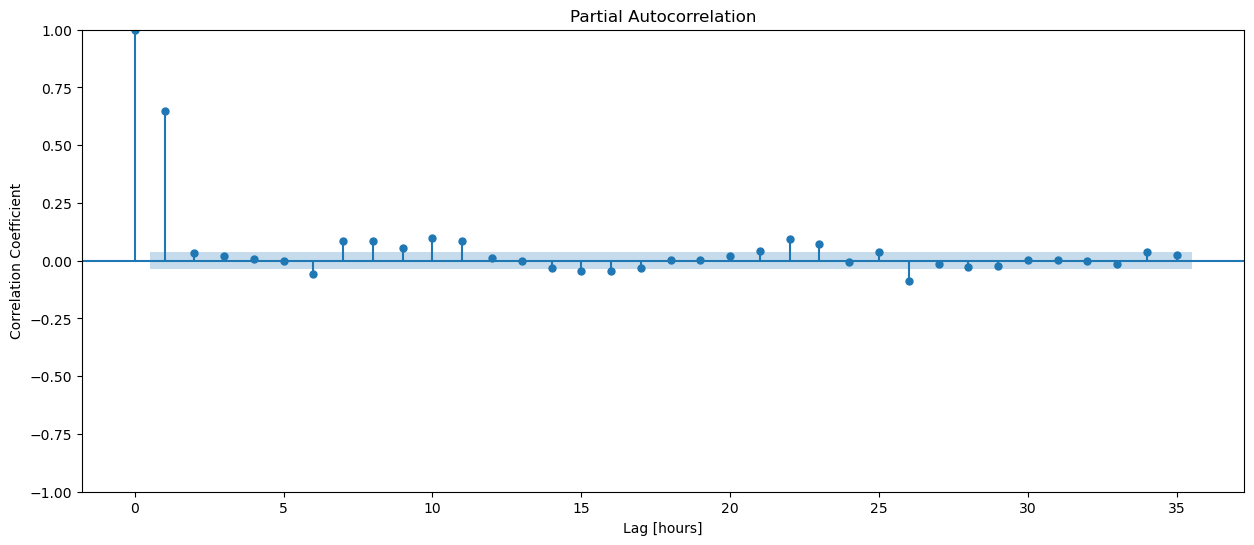

In [123]:
# PACF plot for the data 
fig,ax=plt.subplots(figsize=(15,6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [124]:
# Split
print(y.loc["2018-11-01 00:00:00+03:00":"2018-11-01 23:00:00+03:00"])
y_train = y.loc['2018-10-01':"2018-10-31"]
y_test = y.loc["2018-11-01"]

timestamp
2018-11-01 00:00:00+03:00     5.556364
2018-11-01 01:00:00+03:00     5.664167
2018-11-01 02:00:00+03:00     5.835000
2018-11-01 03:00:00+03:00     7.992500
2018-11-01 04:00:00+03:00     6.785000
2018-11-01 05:00:00+03:00    10.778333
2018-11-01 06:00:00+03:00    10.367500
2018-11-01 07:00:00+03:00     8.879091
2018-11-01 08:00:00+03:00    12.749167
2018-11-01 09:00:00+03:00     7.260000
2018-11-01 10:00:00+03:00     5.245833
2018-11-01 11:00:00+03:00     4.678333
2018-11-01 12:00:00+03:00     5.269167
2018-11-01 13:00:00+03:00     6.843333
2018-11-01 14:00:00+03:00     6.380833
2018-11-01 15:00:00+03:00     7.417500
2018-11-01 16:00:00+03:00     6.193333
2018-11-01 17:00:00+03:00     6.680833
2018-11-01 18:00:00+03:00     8.124167
2018-11-01 19:00:00+03:00     9.923333
2018-11-01 20:00:00+03:00    10.882500
2018-11-01 21:00:00+03:00     9.876667
2018-11-01 22:00:00+03:00    11.137500
2018-11-01 23:00:00+03:00    12.420833
Freq: H, Name: P2, dtype: float64


In [125]:
# Build Model
# Baseline
# the baseline mean absolute error
y_train_mean=y_train.mean()
baseline=[y_train_mean]*len(y_train)
mae_baseline=mean_absolute_error(y_train,baseline)
print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 10.12
Baseline MAE: 4.17


In [126]:
# Iterate
p_params = range(0,25,8)
q_params = range(0,3,1)
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.3 seconds.
Trained ARIMA (0, 0, 1) in 0.15 seconds.
Trained ARIMA (0, 0, 2) in 0.22 seconds.
Trained ARIMA (8, 0, 0) in 0.57 seconds.
Trained ARIMA (8, 0, 1) in 2.32 seconds.


C:\Users\PanDa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (8, 0, 2) in 3.67 seconds.
Trained ARIMA (16, 0, 0) in 1.69 seconds.
Trained ARIMA (16, 0, 1) in 5.01 seconds.


C:\Users\PanDa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (16, 0, 2) in 7.59 seconds.
Trained ARIMA (24, 0, 0) in 7.22 seconds.
Trained ARIMA (24, 0, 1) in 8.3 seconds.


C:\Users\PanDa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (24, 0, 2) in 15.63 seconds.
{0: [4.1714604440324505, 3.350642743173172, 3.1057222590639153], 8: [2.93844805696381, 2.914901916934027, 2.913995185540003], 16: [2.9201084726597633, 2.9294360020038277, 2.9159161839005603], 24: [2.914390329170895, 2.9136013229944817, 2.8979087898950846]}


In [127]:
# DataFrame from mae_df
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,4.1715,2.9384,2.9201,2.9144
1,3.3506,2.9149,2.9294,2.9136
2,3.1057,2.9140,2.9159,2.8979


<Axes: >

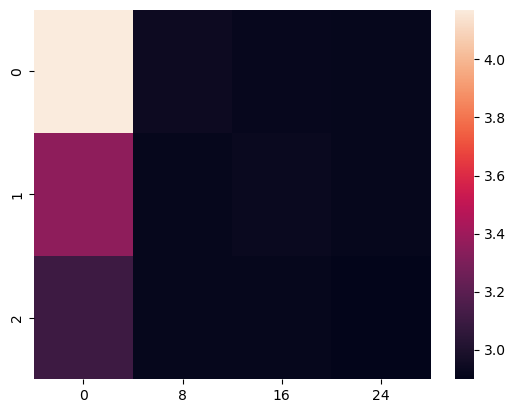

In [128]:
# mae_df heatmap
sns.heatmap(mae_df)

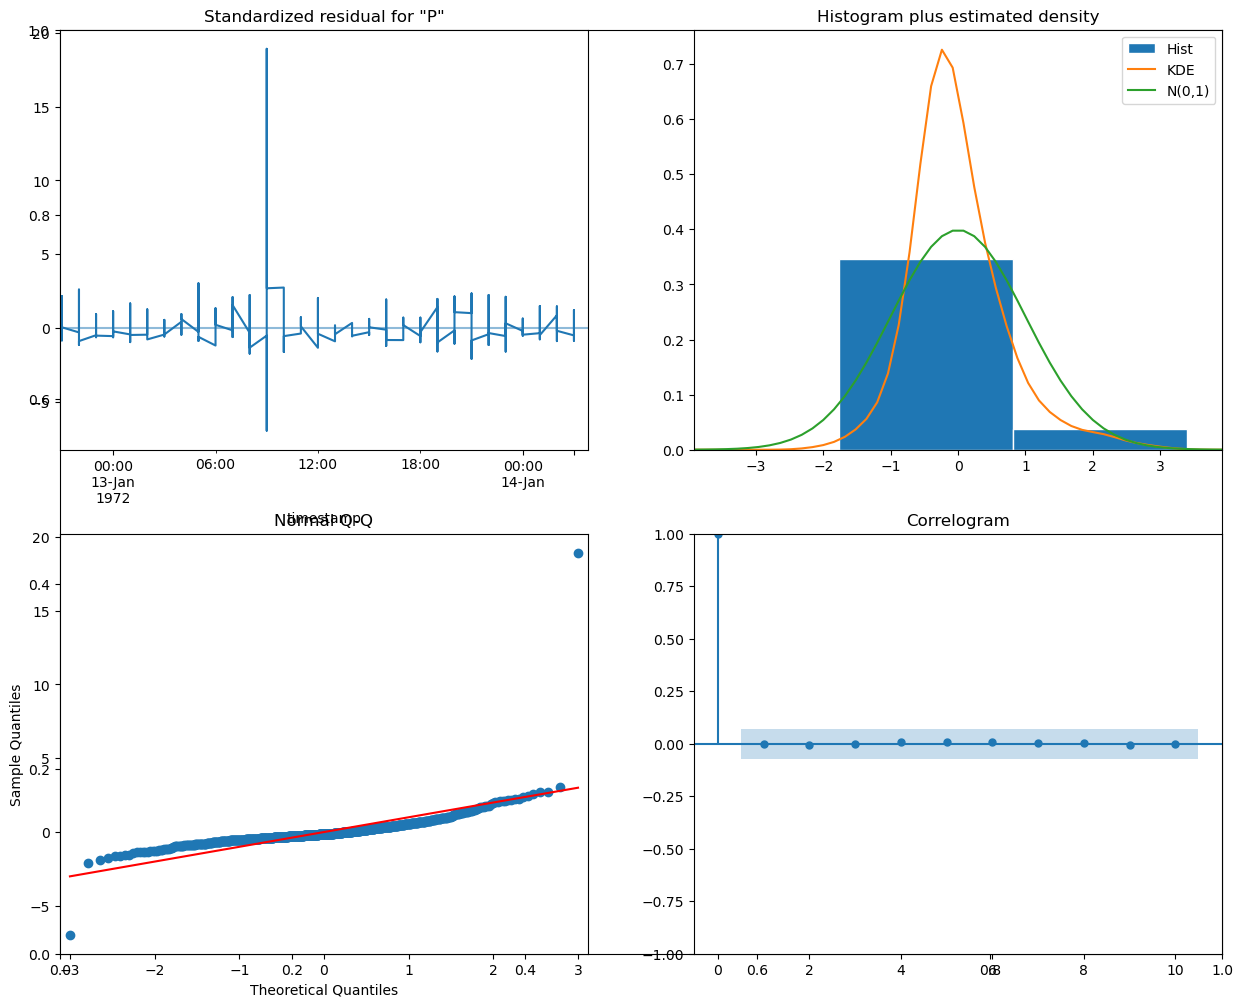

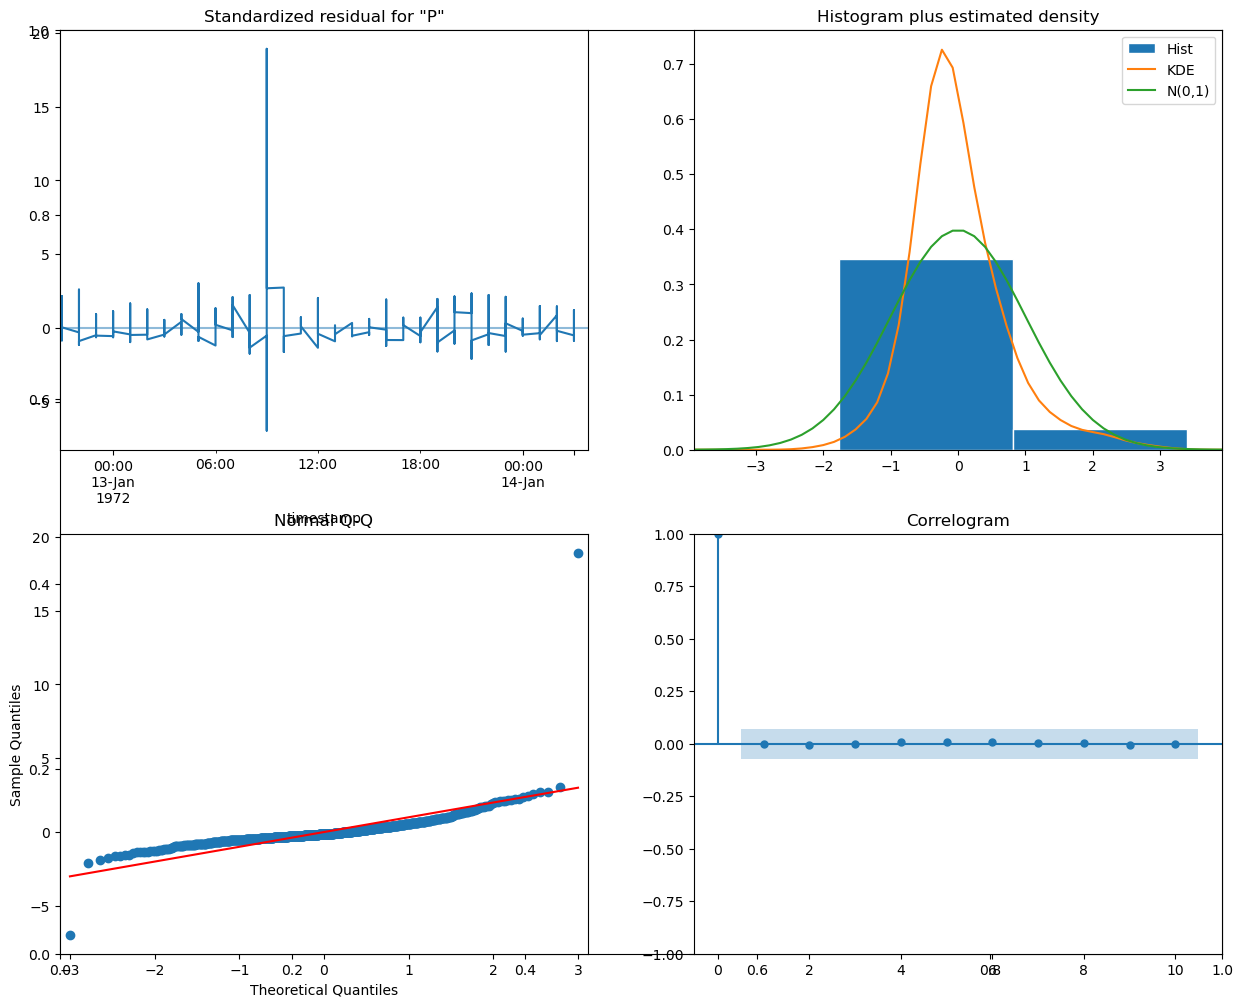

In [129]:
# the time series model residuals
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig)

In [132]:
# Evaluate
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history,order=(8,0,1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:2: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a fu

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

Test MAE (walk forward validation): 1.67


C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3229357631.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [133]:
y_pred_wfv

2018-11-01 00:00:00+03:00     8.725740
2018-11-01 01:00:00+03:00     7.988511
2018-11-01 02:00:00+03:00     7.133805
2018-11-01 03:00:00+03:00     6.372285
2018-11-01 04:00:00+03:00     7.539867
2018-11-01 05:00:00+03:00     8.538572
2018-11-01 06:00:00+03:00    10.757823
2018-11-01 07:00:00+03:00    10.611658
2018-11-01 08:00:00+03:00     9.914120
2018-11-01 09:00:00+03:00    10.911412
2018-11-01 10:00:00+03:00     9.094044
2018-11-01 11:00:00+03:00     7.250349
2018-11-01 12:00:00+03:00     6.515896
2018-11-01 13:00:00+03:00     7.184177
2018-11-01 14:00:00+03:00     6.864491
2018-11-01 15:00:00+03:00     7.564167
2018-11-01 16:00:00+03:00     8.732164
2018-11-01 17:00:00+03:00     8.295855
2018-11-01 18:00:00+03:00     8.199158
2018-11-01 19:00:00+03:00     8.293687
2018-11-01 20:00:00+03:00     9.204907
2018-11-01 21:00:00+03:00     9.629578
2018-11-01 22:00:00+03:00     9.658772
2018-11-01 23:00:00+03:00    10.351504
Freq: H, dtype: float64

In [134]:
# Communicate Results
df_predictions = pd.DataFrame({"y_test":y_test,"y_pred_wfv":y_pred_wfv})
fig = px.line(df_predictions,labels={"value":"PM2.5"})
fig.show()